In [93]:
%matplotlib notebook

import re
import os
import sys
import math
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import product
from scipy.stats import sem, norm
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

In [94]:
def get_label_name(run_dict):
    value_translation = {"decoherence": "dec", "fixed_lde_attempts": "decoupling"}
    keep_key = ['pg', 'pn', 'pm', 'pm_1']
    name = ""
    for key, value in run_dict.items():
        if value is not False:
            if key in value_translation:
                value = value_translation[key]
            name += "{}{}, ".format(key + "=" if key in keep_key else "", str(value).replace("_swap", ""))

    name = name.strip(", ")

    return name

In [95]:
def keep_rows_to_evaluate(df, ev_values):
    for key, values in ev_values.items():
        values = values + [str(i) for i in values]  # Usage: if dataframe parses the values as strings
        
        if values and 'REMOVE' not in values:
            df = df[df[key].isin(values)]
        elif 'REMOVE' not in values:
            ev_values[key] = set(df[key])

    if df.empty:
        print("The combination of values does not exist in the dataframe!", file=sys.stderr)
        raise
        
    return df

In [96]:
def plot_style(title=None, xlabel=None, ylabel=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.08, bottom=0.08, right=.95, top=.95)
    ax.grid(color='w', linestyle='-', linewidth=2)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    for key, arg in kwargs.items():
        func = getattr(ax, f"set_{key}")
        func(arg)
    ax.patch.set_facecolor('0.95')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    return fig, ax

In [97]:
def filter_evaluate_values(df, values, x_axis):
    new_dict = {}
    for key, value in values.items():
        if len(value) > 1 and key != x_axis:
            new_dict[key] = value

    df.set_index(list(new_dict.keys()), inplace=True)
    df.sort_index(inplace=True)
    indices = []
    index_dicts = []

    for index in product(*new_dict.values()):
        index = index if len(index) > 1 else index[0]
        if index in df.index:
            index_dict = dict(zip(new_dict.keys(), index if type(index) != str else [index]))
            indices.append(index)
            index_dicts.append(index_dict)

    # Show the fixed parameters
    print("The following values are fixed:")
    print_parameters = []
    for column in df:
        val = set(df[column])
        if len(val) == 1:
            print_parameters.append("\t[+] {}={}\n".format(column, list(val)[0]))

    # Remove keys from the dicts that have a fixed value (such that the legend only shows varying parameters)
    full_dict = defaultdict(list)
    [full_dict[k].append(v) for d in index_dicts for k, v in d.items()]
    for k, v in full_dict.items():
        if len(set(v)) == 1:
            [d.pop(k) for d in index_dicts]
            print_parameters.append("\t[+] {}={}\n".format(k, v[0]))
    print(*sorted(print_parameters))

    return df, indices, index_dicts

In [98]:
def pre_process_results(df, values, x_axis):
    df = df.reset_index()
    df = keep_rows_to_evaluate(df, values)
    df, indices, index_dicts = filter_evaluate_values(df, values, x_axis)

    return df, indices, index_dicts

In [99]:
def plot_non_local_cnot_fidelity(df, x_axis, evaluate_values, spread=False,
                                 ent_fid=False):
    fig, ax = plot_style(title="Non-local CNOT gate", xlabel=x_axis, ylabel="Average fidelity")
    df, indices, index_dicts = pre_process_results(df, evaluate_values, x_axis)

    for index_tuple, index_dict in zip(indices, index_dicts):
        x_axis_data = df.loc[index_tuple, x_axis]
        ax.errorbar(x_axis_data,
                    df.loc[index_tuple, 'avg_fidelity'],
                    yerr=None if not spread else [df.loc[index_tuple, 'fid_std_l'],
                                                  df.loc[index_tuple, 'fid_std_r']],
                    ms=8,
                    fmt='-o',
                    capsize=8,
                    label=get_label_name(index_dict))
        if ent_fid:
            ax.errorbar(x_axis_data,
                        df.loc[index_tuple, 'fid_entanglement'],
                        fmt='-o',
                        label="{} - {}".format(get_label_name(index_dict), "$F_{e}$"))
        ax.set_xlim(max(x_axis_data) + 0.001, min(x_axis_data) - 0.001)

    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, prop={'size': 18})
    plt.show()

In [100]:
def main(x_axis, evaluate_values, spread, ent_fid):
    dataframe = pd.read_csv('non_local_cnot_full.csv', sep=';', float_precision='round_trip')
    
    plot_non_local_cnot_fidelity(dataframe, x_axis, evaluate_values, spread=spread,
                                 ent_fid=ent_fid)

<IPython.core.display.Javascript object>


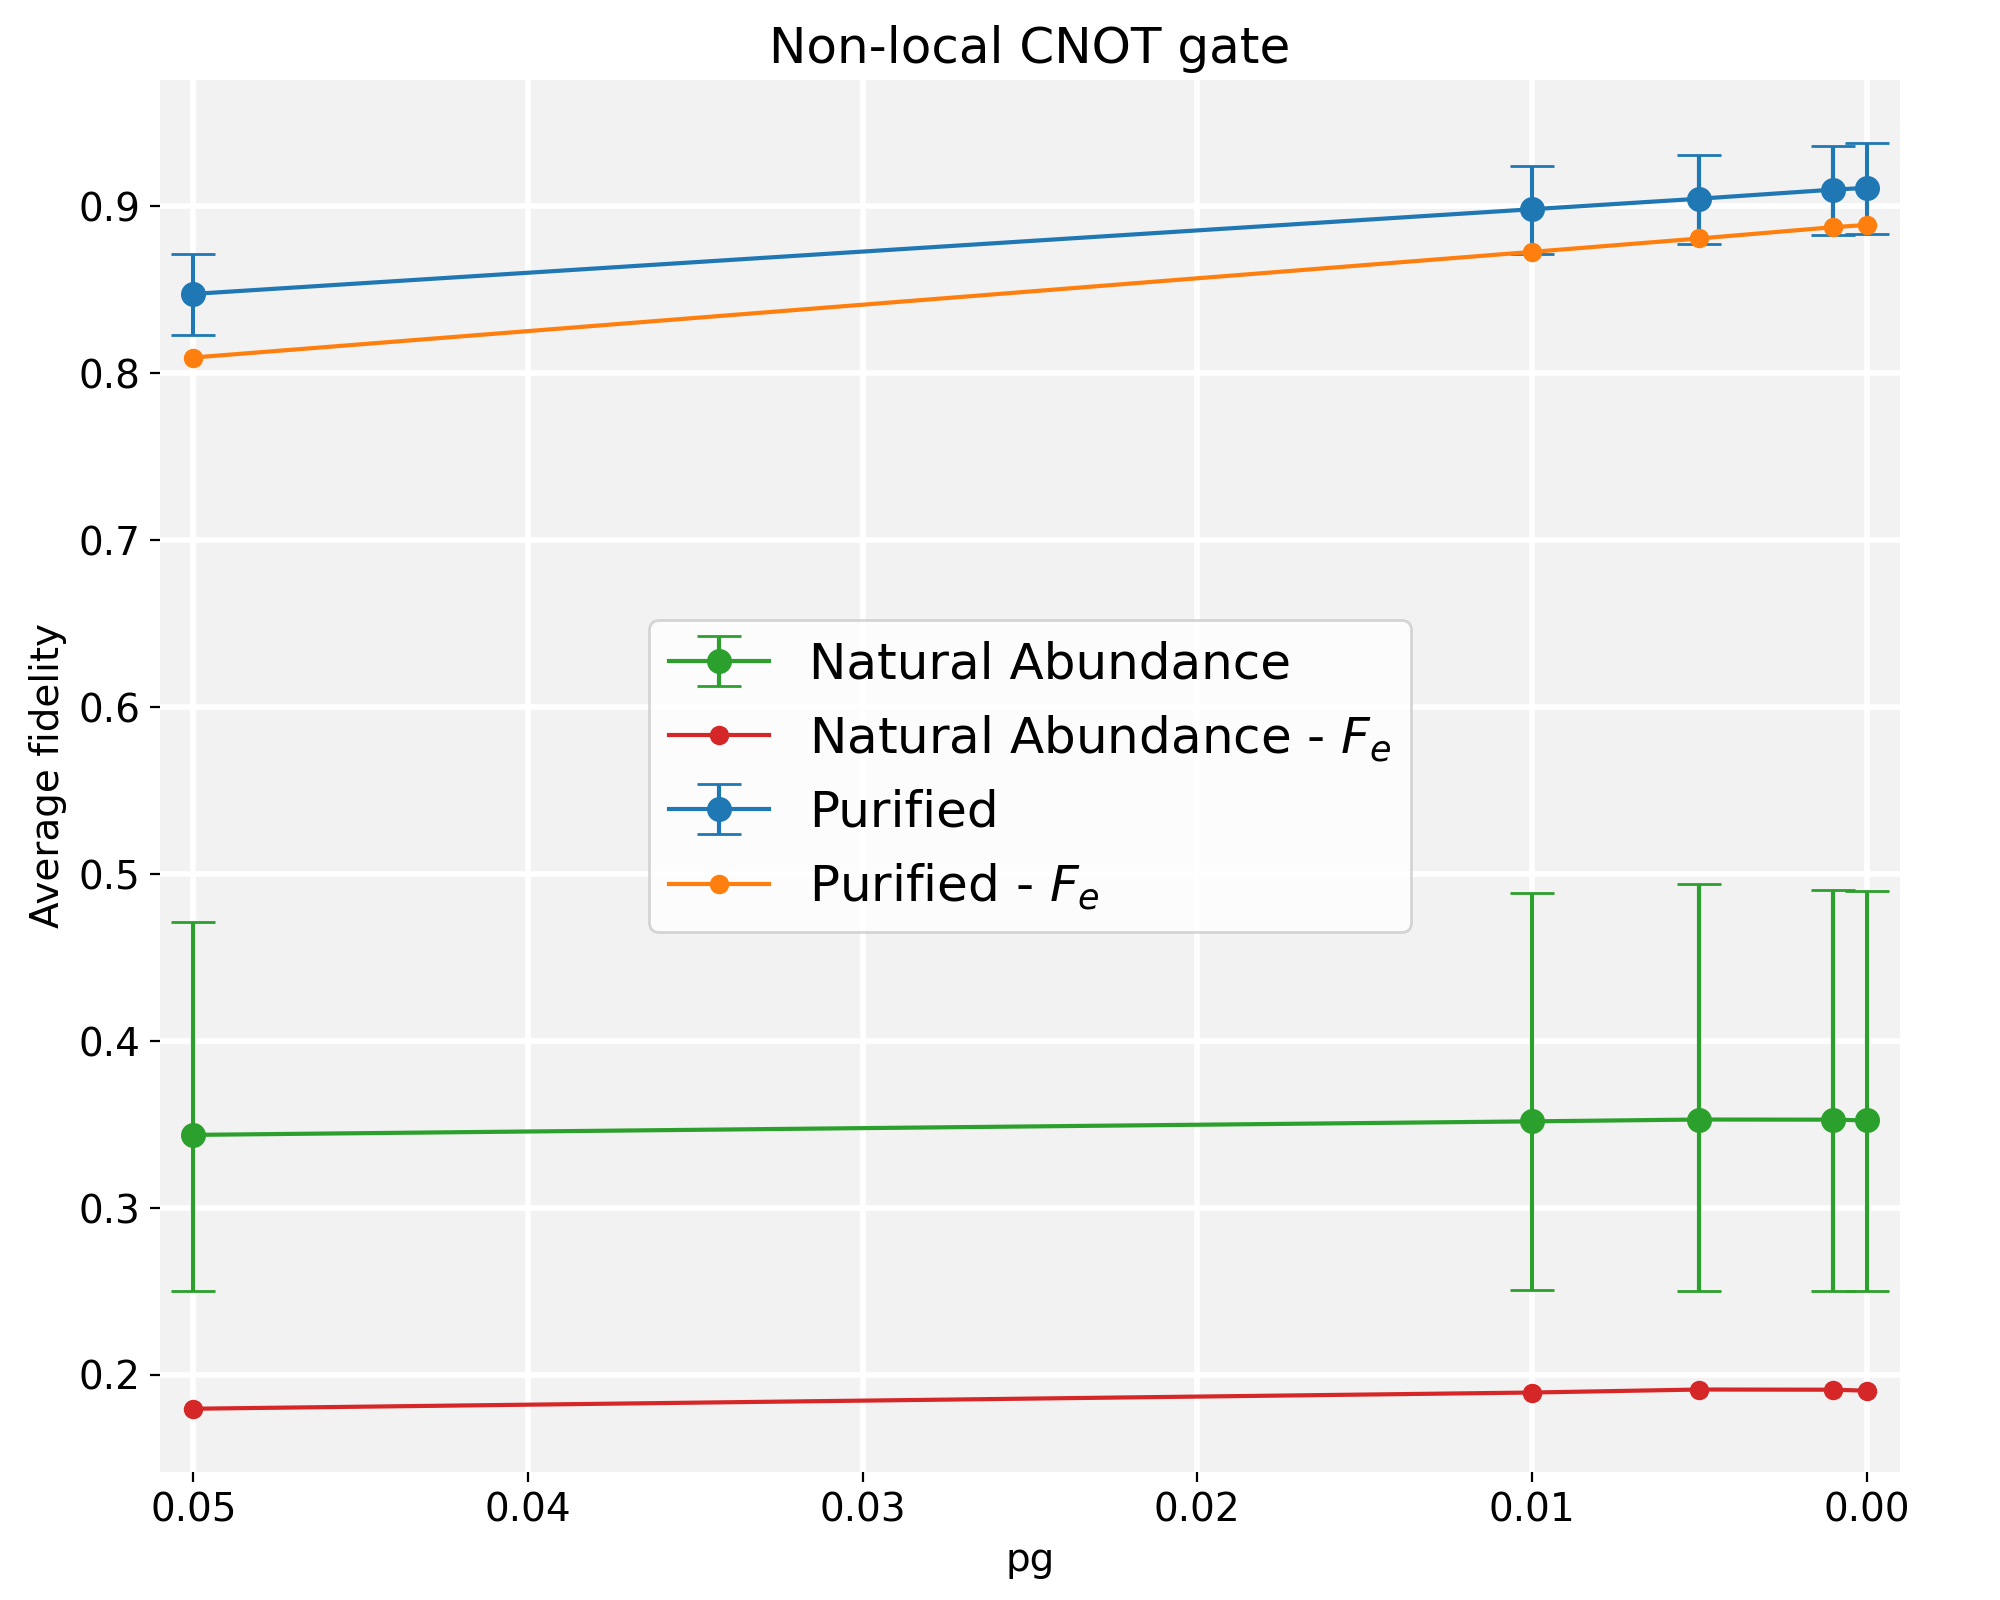

The following values are fixed:
	[+] T2_idle=10.0
 	[+] basis_transformation_noise=False
 	[+] decoherence=True
 	[+] fixed_lde_attempts=2000
 	[+] gate=cnot
 	[+] lde_duration=6e-06
 	[+] lde_success=0.0001
 	[+] measurement_duration=4e-06
 	[+] network_noise_type=1
 	[+] no_single_qubit_error=True
 	[+] noise=True
 	[+] pm=0.01
 	[+] pm_1=0.01
 	[+] pn=0.1
 	[+] probabilistic=True
 	[+] use_swap_gates=True



In [101]:
###### USER INPUT ########

spread = True
ent_fid = True

evaluate_values = {'node':                  [],
                   'decoherence':           [True],
                   'fixed_lde_attempts':    [2000],
                   'lde_success':           [0.0001],
                   'pg':                    [],
                   'pm':                    [],
                   'pm_1':                  [0.01],
                   'pn':                    [0.1]
                   }
x_axis = "pg"

main(x_axis, evaluate_values, spread, ent_fid)